**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Intro to Random Forests

### Your practice

People learn by:
1. **doing** (coding and building)
2. **explaining** what they've learned (by writing or helping others)

Therefore, we suggest that you practice these skills on Kaggle by:
1. Entering competitions (*doing*)
2. Creating Kaggle kernels (*explaining*)

It's OK if you don't get good competition ranks or any kernel votes at first - that's totally normal! Just try to keep improving every day, and you'll see the results over time.

To get better at technical writing, study the top ranked Kaggle kernels from past competitions, and read posts from well-regarded technical bloggers. Some good role models include:

- [Peter Norvig](http://nbviewer.jupyter.org/url/norvig.com/ipython/ProbabilityParadox.ipynb) (more [here](http://norvig.com/ipython/))
- [Stephen Merity](https://smerity.com/articles/2017/deepcoder_and_ai_hype.html)
- [Julia Evans](https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture) (more [here](https://jvns.ca/blog/2014/08/12/what-happens-if-you-write-a-tcp-stack-in-python/))
- [Julia Ferraioli](http://blog.juliaferraioli.com/2016/02/exploring-world-using-vision-twilio.html)
- [Edwin Chen](http://blog.echen.me/2014/10/07/moving-beyond-ctr-better-recommendations-through-human-evaluation/)
- [Slav Ivanov](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b) (fast.ai student)
- [Brad Kenstler](https://hackernoon.com/non-artistic-style-transfer-or-how-to-draw-kanye-using-captain-picards-face-c4a50256b814) (fast.ai and USF MSAN student)

### Books

The more familiarity you have with numeric programming in Python, the better. If you're looking to improve in this area, we strongly suggest Wes McKinney's [Python for Data Analysis, 2nd ed](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1491957662/ref=asap_bc?ie=UTF8).

For machine learning with Python, we recommend:

- [Introduction to Machine Learning with Python](https://www.amazon.com/Introduction-Machine-Learning-Andreas-Mueller/dp/1449369413): From one of the scikit-learn authors, which is the main library we'll be using
- [Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1787125939/ref=dp_ob_title_bk): New version of a very successful book. A lot of the new material however covers deep learning in Tensorflow, which isn't relevant to this course
- [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=MBV2QMFH3EZ6B3YBY40K)


## Imports
Magic commands:
- Reload modules before executing user code.
- Show matplotlib graphs in notebook style.

In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from scipy import stats

In [7]:
PATH = "../data/census/"

In [8]:
!ls {PATH}

census.csv  census.names  census.test  tmp


Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

1. Interesting data sets
2. Feedback on how you're doing
3. A leader board to see what's good, what's possible, and what's state-of-art.
4. Blog posts by winning contestants share useful tips and techniques.

## The data

### Look at the data

##### Data Set Information:

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)) 

Prediction task is to determine whether a person makes over 50K a year. 


##### Attribute Information:

Listing of attributes: 

>50K, <=50K. 

- age: continuous. 
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
- fnlwgt: continuous. 
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
- education-num: continuous. 
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- sex: Female, Male. 
- capital-gain: continuous. 
- capital-loss: continuous. 
- hours-per-week: continuous. 
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [9]:
df_raw = pd.read_csv(f'{PATH}census.csv', low_memory=False)
df_raw.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'Class']

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [10]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [11]:
display_all(df_raw.tail().T)

,32556,32557,32558,32559,32560
age,27,40,58,22,52
workclass,Private,Private,Private,Private,Self-emp-inc
fnlwgt,257302,154374,151910,201490,287927
education,Assoc-acdm,HS-grad,HS-grad,HS-grad,HS-grad
education_num,12,9,9,9,9
marital_status,Married-civ-spouse,Married-civ-spouse,Widowed,Never-married,Married-civ-spouse
occupation,Tech-support,Machine-op-inspct,Adm-clerical,Adm-clerical,Exec-managerial
relationship,Wife,Husband,Unmarried,Own-child,Wife
race,White,White,White,White,White
sex,Female,Male,Female,Male,Female


In [12]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,32561,NaN,NaN,NaN,38.5816,13.6404,17,28,37,48,90
workclass,32561,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,32561,NaN,NaN,NaN,189778,105550,12285,117827,178356,237051,1.48470e+06
education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_num,32561,NaN,NaN,NaN,10.0807,2.57272,1,9,10,12,16
marital_status,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,32561,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,32561,2,Male,21790,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. This is a classification problem, so we're gonna be looking at Accuracy.

### Initial processing

In [13]:
m = RandomForestClassifier(n_jobs=-1)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('Class', axis=1), df_raw.Class)

/home/sam/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: ' State-gov'

This dataset contains a mix of **continuous** and **categorical** variables.

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [14]:
train_cats(df_raw)
#df_raw.describe()

We can specify the order to use for categorical variables if we wish:

In [15]:
df_raw.education.cat.categories

Index([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th',
       ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad',
       ' Masters', ' Preschool', ' Prof-school', ' Some-college'],
      dtype='object')

In [16]:
#df_raw.UsageBand.cat.set_categories(['x', 'b', 'o'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [17]:
#df_raw.a1 = df_raw.a1.cat.codes

Do we have missing values? We can't pass these directly to a random forest.

In [18]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Class             0.0
age               0.0
capital_gain      0.0
capital_loss      0.0
education         0.0
education_num     0.0
fnlwgt            0.0
hours_per_week    0.0
marital_status    0.0
native_country    0.0
occupation        0.0
race              0.0
relationship      0.0
sex               0.0
workclass         0.0
dtype: float64

Nope! 
Luckily the UCI database has clean datasets.
We will look at dirty datasets in future classes.

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [19]:
os.makedirs(f'{PATH}tmp', exist_ok=True)
df_raw.to_feather(f'{PATH}tmp/census-raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [20]:
df_raw = pd.read_feather(f'{PATH}tmp/census-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [21]:
df, y, _ = proc_df(df_raw, 'Class')

We now have something we can pass to a random forest!

In [22]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

/home/sam/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9880531924695187

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [23]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_test = 6400
n_trn = len(df)-n_test
raw_train, raw_test = split_vals(df_raw, n_trn)
X_train, X_test = split_vals(df, n_trn)
y_train, y_test = split_vals(y, n_trn)
X_train.shape, y_train.shape, X_test.shape

((26161, 14), (26161,), (6400, 14))

In [24]:
n_valid = 5000
n_trn = len(X_train)-n_valid
X_train, X_valid = split_vals(X_train, n_trn)
y_train, y_valid = split_vals(y_train, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((21161, 14), (21161,), (5000, 14))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [25]:
def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    print(res)

In [26]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/home/sam/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 313 ms, sys: 7.17 ms, total: 321 ms
Wall time: 212 ms
[0.9871461651150701, 0.8498]


## Single tree

In [27]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.811681867586598, 0.8132]


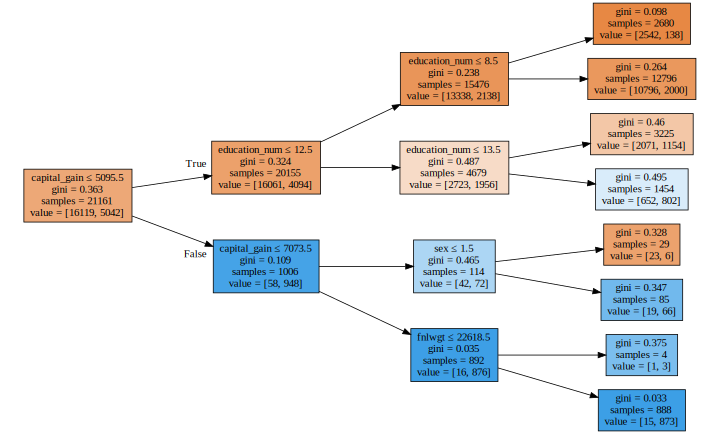

In [28]:
df_trn = X_train
draw_tree(m.estimators_[0], df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [29]:
m = RandomForestClassifier(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.0, 0.802]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [30]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9993384055573933, 0.8544]


We'll grab the predictions for each individual tree, and look at one example.

In [31]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.]), 0.475, 0)

In [32]:
preds.shape

(40, 5000)

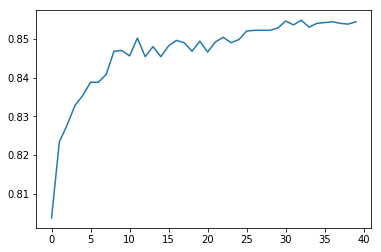

In [34]:
plt.plot([metrics.accuracy_score(y_valid, stats.mode(preds[:i+1], axis=0)[0][0]) for i in range(40)]);
#metrics.accuracy_score

The shape of this curve suggests that at a certain point, adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample). There may be better ways to improve accuracy. 

In [35]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9991493785737914, 0.8624]


In [36]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.9999527432540996, 0.8594]


In [37]:
m = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.0, 0.8628]


In [38]:
m.fit(X_train, y_train)
m.score(X_test, y_test)

0.8596875